## ELETTRA-29: ID response

In [1]:
# The linear transport matrix of an ID can be represented by exp(S A) with Aij = Aji
# LPUs have diagonal matrix A, while non-zero skew diagonal elements are present EPUs (other elements are also not equal to zero in general)
# In this example derivatives of tunes and beta functions with respect to diagonal and skew diagonal elements are evaluated

In [2]:
# Import

import torch
from torch import Tensor

from pathlib import Path

import matplotlib
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
matplotlib.rcParams['text.usetex'] = True

from model.library.element import Element
from model.library.line import Line
from model.library.quadrupole import Quadrupole
from model.library.matrix import Matrix

from model.command.external import load_lattice
from model.command.build import build
from model.command.tune import tune
from model.command.orbit import dispersion
from model.command.twiss import twiss
from model.command.advance import advance
from model.command.coupling import coupling
from model.command.layout import Layout

In [3]:
# Set data type and device

Element.dtype = dtype = torch.float64
Element.device = device = torch.device('cpu')

In [4]:
# Load lattice (ELEGANT table)
# Note, lattice is allowed to have repeated elements

path = Path('elettra.lte')
data = load_lattice(path)

In [5]:
# Build and setup lattice

ring:Line = build('RING', 'ELEGANT', data)

# Flatten sublines

ring.flatten()

# Remove all marker elements but the ones starting with MLL (long straight section centers)

ring.remove_group(pattern=r'^(?!MLL_).*', kinds=['Marker'])

# Replace all sextupoles with quadrupoles

def factory(element:Element) -> None:
    table = element.serialize
    table.pop('ms', None)
    return Quadrupole(**table)

ring.replace_group(pattern=r'', factory=factory, kinds=['Sextupole'])

# Set linear dipoles

def apply(element:Element) -> None:
    element.linear = True

ring.apply(apply, kinds=['Dipole'])

# Merge drifts

ring.merge()

# Change lattice start

ring.start = "BPM_S01_01"

# Describe

ring.describe

{'BPM': 168, 'Drift': 708, 'Dipole': 156, 'Quadrupole': 360, 'Marker': 12}

In [6]:
# Define empty ID model
# Note, only the flattened triangular part of the A and B matrices will be passed

# A = [a11, a12, a13, a14, a22, a23, a24, a33, a34, a44]

# a11, a22, a33, a44 -- diagonal elements
# a14, a23           -- skew diagonal

X = Matrix('X', length=0.0)

In [7]:
# Insert empty ID into the existing lattice
# This will replace the target marker

ring.insert(X, 'MLL_S01', position=0.0)
ring.describe

{'BPM': 168,
 'Drift': 708,
 'Dipole': 156,
 'Quadrupole': 360,
 'Matrix': 1,
 'Marker': 11}

In [8]:
# Define parametric observables

def observable_tunes(a11, a12, a13, a14, a22, a23, a24, a33, a34, a44):
    parameters = [a11, a12, a13, a14, a22, a23, a24, a33, a34, a44]
    groups = (
        ('a11', None, ['X'], None),
        ('a12', None, ['X'], None),
        ('a13', None, ['X'], None),
        ('a14', None, ['X'], None),
        ('a22', None, ['X'], None),
        ('a23', None, ['X'], None),
        ('a24', None, ['X'], None),
        ('a33', None, ['X'], None),
        ('a34', None, ['X'], None),
        ('a44', None, ['X'], None)
    )    
    nux, nuy = tune(ring, parameters, *groups, matched=True)
    return torch.stack([nux, nuy])

def observable_twiss(a11, a12, a13, a14, a22, a23, a24, a33, a34, a44):
    parameters = [a11, a12, a13, a14, a22, a23, a24, a33, a34, a44]
    groups = (
        ('a11', None, ['X'], None),
        ('a12', None, ['X'], None),
        ('a13', None, ['X'], None),
        ('a14', None, ['X'], None),
        ('a22', None, ['X'], None),
        ('a23', None, ['X'], None),
        ('a24', None, ['X'], None),
        ('a33', None, ['X'], None),
        ('a34', None, ['X'], None),
        ('a44', None, ['X'], None)
    )    
    _, bx, _, by = twiss(ring, parameters, *groups, matched=True, advance=True, full=False).T
    return torch.stack([bx, by])

In [9]:
# Compute tunes derivatives

# a11, a22, a33, a44 -- diagonal elements
# a14, a23           -- skew diagonal

a11, a12, a13, a14, a22, a23, a24, a33, a34, a44 = torch.split(torch.tensor(10*[0.0], dtype=dtype), 10*[1])

print(torch.func.jacfwd(lambda a11: observable_tunes(a11, a12, a13, a14, a22, a23, a24, a33, a34, a44))(a11))
print(torch.func.jacfwd(lambda a22: observable_tunes(a11, a12, a13, a14, a22, a23, a24, a33, a34, a44))(a22))
print(torch.func.jacfwd(lambda a33: observable_tunes(a11, a12, a13, a14, a22, a23, a24, a33, a34, a44))(a33))
print(torch.func.jacfwd(lambda a44: observable_tunes(a11, a12, a13, a14, a22, a23, a24, a33, a34, a44))(a44))
print()

print(torch.func.jacfwd(lambda a14: observable_tunes(a11, a12, a13, a14, a22, a23, a24, a33, a34, a44))(a14))
print(torch.func.jacfwd(lambda a23: observable_tunes(a11, a12, a13, a14, a22, a23, a24, a33, a34, a44))(a23))
print()

tensor([[0.7492],
        [0.0000]], dtype=torch.float64)
tensor([[0.0085],
        [0.0000]], dtype=torch.float64)
tensor([[0.0000],
        [0.1305]], dtype=torch.float64)
tensor([[0.0000],
        [0.0485]], dtype=torch.float64)

tensor([[0.],
        [0.]], dtype=torch.float64)
tensor([[0.],
        [0.]], dtype=torch.float64)



In [10]:
# Compute twiss derivatives

# a11, a22, a33, a44 -- diagonal elements
# a14, a23           -- skew diagonal

a11, a12, a13, a14, a22, a23, a24, a33, a34, a44 = torch.split(torch.tensor(10*[0.0], dtype=dtype), 10*[1])

dbxda11, dbyda11 = torch.func.jacfwd(lambda a11: observable_twiss(a11, a12, a13, a14, a22, a23, a24, a33, a34, a44))(a11).squeeze()
dbxda22, dbyda22 = torch.func.jacfwd(lambda a22: observable_twiss(a11, a12, a13, a14, a22, a23, a24, a33, a34, a44))(a22).squeeze()
dbxda33, dbyda33 = torch.func.jacfwd(lambda a33: observable_twiss(a11, a12, a13, a14, a22, a23, a24, a33, a34, a44))(a33).squeeze()
dbxda44, dbyda44 = torch.func.jacfwd(lambda a44: observable_twiss(a11, a12, a13, a14, a22, a23, a24, a33, a34, a44))(a44).squeeze()

dbxda14, dbyda14 = torch.func.jacfwd(lambda a14: observable_twiss(a11, a12, a13, a14, a22, a23, a24, a33, a34, a44))(a14).squeeze()
dbxda23, dbyda23 = torch.func.jacfwd(lambda a23: observable_twiss(a11, a12, a13, a14, a22, a23, a24, a33, a34, a44))(a23).squeeze()

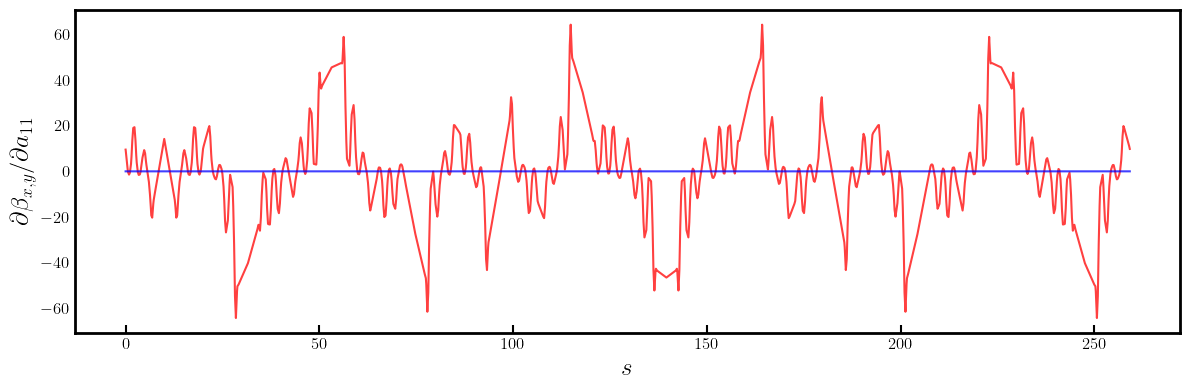

In [11]:
# Plot a11 derivatives

fig, ax = plt.subplots(figsize=(12, 4))
ax.errorbar(ring.locations().cpu().numpy(), dbxda11.cpu().numpy(), fmt='-', color='red', alpha=0.75)
ax.errorbar(ring.locations().cpu().numpy(), dbyda11.cpu().numpy(), fmt='-', color='blue', alpha=0.75)
ax.tick_params(axis='x', length=6, width=1.5, direction='in', labelsize=12, bottom=True, top=False, labelbottom=True, labeltop=False)
ax.tick_params(axis='y', length=0, width=0, labelsize=12)
ax.set_xlabel(r'$s$', fontsize=18)
ax.set_ylabel(r'$\partial \beta_{x,y} / \partial a_{11}$', fontsize=18)
plt.setp(ax.spines.values(), linewidth=2.0)
plt.tight_layout()
plt.show()

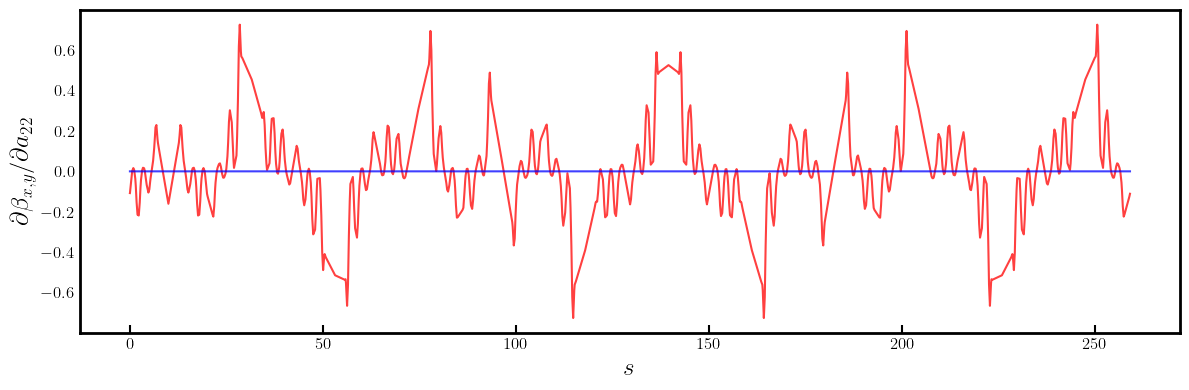

In [12]:
# Plot a22 derivatives

fig, ax = plt.subplots(figsize=(12, 4))
ax.errorbar(ring.locations().cpu().numpy(), dbxda22.cpu().numpy(), fmt='-', color='red', alpha=0.75)
ax.errorbar(ring.locations().cpu().numpy(), dbyda22.cpu().numpy(), fmt='-', color='blue', alpha=0.75)
ax.tick_params(axis='x', length=6, width=1.5, direction='in', labelsize=12, bottom=True, top=False, labelbottom=True, labeltop=False)
ax.tick_params(axis='y', length=0, width=0, labelsize=12)
ax.set_xlabel(r'$s$', fontsize=18)
ax.set_ylabel(r'$\partial \beta_{x,y} / \partial a_{22}$', fontsize=18)
plt.setp(ax.spines.values(), linewidth=2.0)
plt.tight_layout()
plt.show()

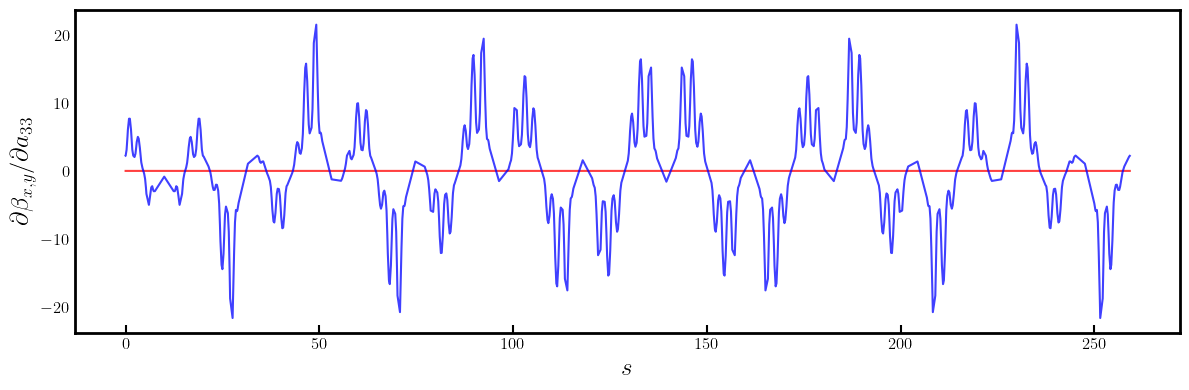

In [13]:
# Plot a33 derivatives

fig, ax = plt.subplots(figsize=(12, 4))
ax.errorbar(ring.locations().cpu().numpy(), dbxda33.cpu().numpy(), fmt='-', color='red', alpha=0.75)
ax.errorbar(ring.locations().cpu().numpy(), dbyda33.cpu().numpy(), fmt='-', color='blue', alpha=0.75)
ax.tick_params(axis='x', length=6, width=1.5, direction='in', labelsize=12, bottom=True, top=False, labelbottom=True, labeltop=False)
ax.tick_params(axis='y', length=0, width=0, labelsize=12)
ax.set_xlabel(r'$s$', fontsize=18)
ax.set_ylabel(r'$\partial \beta_{x,y} / \partial a_{33}$', fontsize=18)
plt.setp(ax.spines.values(), linewidth=2.0)
plt.tight_layout()
plt.show()

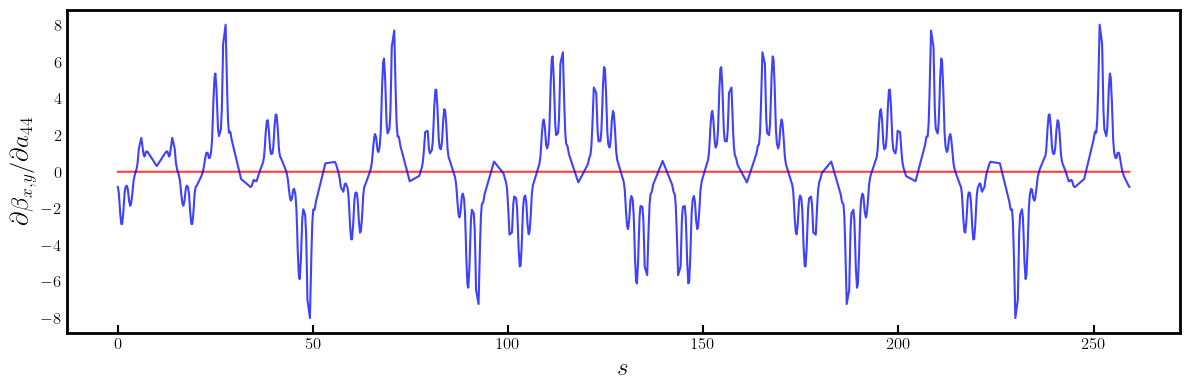

In [14]:
# Plot a44 derivatives

fig, ax = plt.subplots(figsize=(12, 4))
ax.errorbar(ring.locations().cpu().numpy(), dbxda44.cpu().numpy(), fmt='-', color='red', alpha=0.75)
ax.errorbar(ring.locations().cpu().numpy(), dbyda44.cpu().numpy(), fmt='-', color='blue', alpha=0.75)
ax.tick_params(axis='x', length=6, width=1.5, direction='in', labelsize=12, bottom=True, top=False, labelbottom=True, labeltop=False)
ax.tick_params(axis='y', length=0, width=0, labelsize=12)
ax.set_xlabel(r'$s$', fontsize=18)
ax.set_ylabel(r'$\partial \beta_{x,y} / \partial a_{44}$', fontsize=18)
plt.setp(ax.spines.values(), linewidth=2.0)
plt.tight_layout()
plt.show()